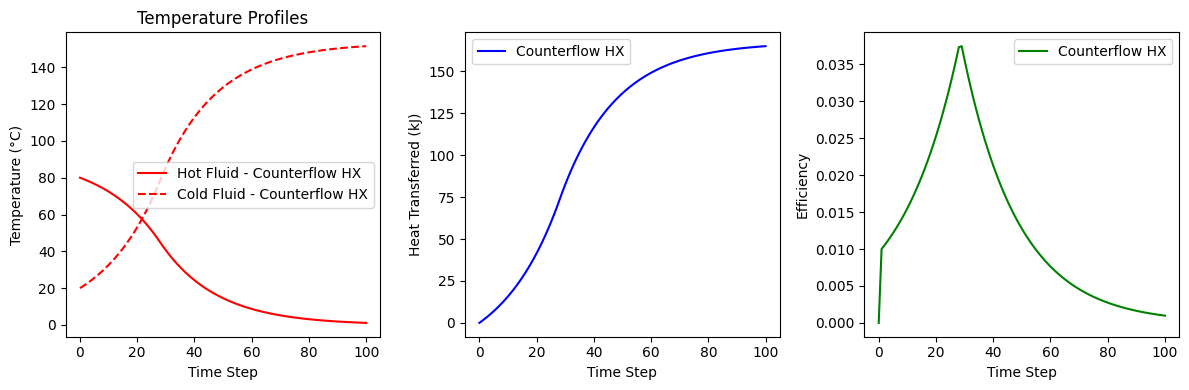

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class HeatExchanger(object):
    """Abstract class for modeling heat exchanger performance over time"""

    def __init__(self, hot_in_temp, cold_in_temp, hot_flow_rate, cold_flow_rate, time_steps):
        """
        Initialize heat exchanger parameters
        :param hot_in_temp: Initial hot fluid temperature (°C)
        :param cold_in_temp: Initial cold fluid temperature (°C)
        :param hot_flow_rate: Hot fluid flow rate (kg/s)
        :param cold_flow_rate: Cold fluid flow rate (kg/s)
        :param time_steps: Number of time steps to simulate
        """
        self._hot_in_temp = hot_in_temp
        self._cold_in_temp = cold_in_temp
        self._hot_flow = hot_flow_rate
        self._cold_flow = cold_flow_rate
        self._time_steps = time_steps
        
        # Tracking variables
        self._hot_temp = [hot_in_temp]  # Hot fluid temperature over time
        self._cold_temp = [cold_in_temp]  # Cold fluid temperature over time
        self._heat_transfer = [0.0]  # Cumulative heat transfer (kJ)
        self._efficiency = [0.0]  # Heat exchanger efficiency over time
        self._legend = None  # Description of heat exchanger type
        
        # Constants
        self._specific_heat = 4.186  # kJ/kg°C (assuming water)
        
    def calculate_heat_transfer(self):
        """Calculate heat transfer for one time step"""
        delta_T_hot = self._hot_temp[-1] - self._hot_temp[-1] * 0.95  # Simplified temp change
        delta_T_cold = self._cold_temp[-1] * 1.05 - self._cold_temp[-1]  # Simplified temp change
        
        Q = min(
            self._hot_flow * self._specific_heat * delta_T_hot,
            self._cold_flow * self._specific_heat * delta_T_cold
        )
        
        self._heat_transfer.append(self._heat_transfer[-1] + Q)
        
        # Update temperatures
        self._hot_temp.append(self._hot_temp[-1] - Q/(self._hot_flow * self._specific_heat))
        self._cold_temp.append(self._cold_temp[-1] + Q/(self._cold_flow * self._specific_heat))
        
        # Calculate efficiency
        max_possible_Q = self._hot_flow * self._specific_heat * (self._hot_in_temp - self._cold_in_temp)
        self._efficiency.append(Q/max_possible_Q if max_possible_Q > 0 else 0)
    
    def get_total_heat_transfer(self):
        """Return total heat transferred"""
        return self._heat_transfer[-1]
    
    def __str__(self):
        return self._legend
    
    def plot_temperatures(self, style):
        """Plot temperature profiles"""
        plt.plot(self._hot_temp, style, label=f'Hot Fluid - {self._legend}')
        plt.plot(self._cold_temp, '--'+style, label=f'Cold Fluid - {self._legend}')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature (°C)')
        plt.legend()
    
    def plot_heat_transfer(self, style):
        """Plot cumulative heat transfer"""
        plt.plot(self._heat_transfer, style, label=self._legend)
        plt.xlabel('Time Step')
        plt.ylabel('Heat Transferred (kJ)')
        plt.legend()
    
    def plot_efficiency(self, style):
        """Plot heat exchanger efficiency over time"""
        plt.plot(self._efficiency, style, label=self._legend)
        plt.xlabel('Time Step')
        plt.ylabel('Efficiency')
        plt.legend()
he = HeatExchanger(80, 20, 0.5, 0.3, 100)
he._legend = "Counterflow HX"
for _ in range(100):
    he.calculate_heat_transfer()

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Temperature Profiles')
he.plot_temperatures('r')
plt.subplot(1, 3, 2)
he.plot_heat_transfer('b-')
plt.subplot(1, 3, 3)
he.plot_efficiency('g-')
plt.tight_layout()
plt.show()   

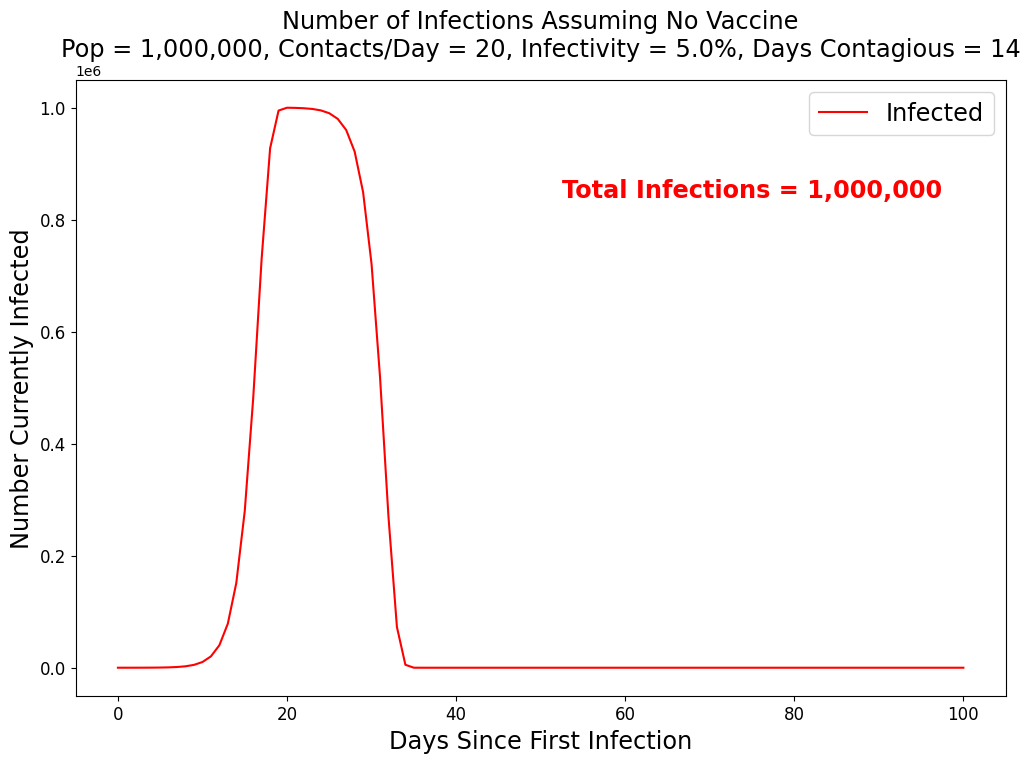

In [9]:
import matplotlib.pyplot as plt

def simulation(fixed, variable):
    """
    Simulates the spread of an infection over time with optional social distancing measures.
    
    Args:
        fixed (dict): Contains fixed parameters for the simulation:
            - initial_infections (int): Starting number of infected individuals
            - duration (int): Number of days to simulate
            - days_spreading (int): Number of days an individual remains contagious
            - pop (int): Total population size
            - init_contacts (int): Normal daily contact rate
            - contagiousness (float): Probability of infection per contact (0-1)
            
        variable (dict): Contains variable parameters for social distancing:
            - red_start (int): Day when social distancing begins
            - red_end (int): Day when social distancing ends
            - red_daily_contacts (int): Reduced contact rate during distancing
            
    Returns:
        tuple: (infected, new_infections, total_infections)
            - infected: List of currently infected individuals each day
            - new_infections: List of new infections each day
            - total_infections: Final cumulative infection count
    """
    infected = [fixed['initial_infections']]
    new_infections = [fixed['initial_infections']]
    total_infections = fixed['initial_infections']
    
    for t in range(fixed['duration']):
        cur_infections = infected[-1]
        
        # Remove people who are no longer contagious
        if len(new_infections) > fixed['days_spreading']:
            cur_infections -= new_infections[-fixed['days_spreading']-1]
            
        # If social distancing, change number of daily contacts
        if t >= variable['red_start'] and t < variable['red_end']:
            daily_contacts = variable['red_daily_contacts']
        else:
            daily_contacts = fixed['init_contacts']
            
        # Compute number of new cases
        total_contacts = cur_infections * daily_contacts
        susceptible = fixed['pop'] - total_infections
        risky_contacts = total_contacts * (susceptible/fixed['pop'])
        newly_infected = round(risky_contacts * fixed['contagiousness'])
        
        # Update variables
        new_infections.append(newly_infected)
        total_infections += newly_infected
        infected.append(cur_infections + newly_infected)
        
    return infected, new_infections, total_infections
def plot_infections(infections, total_infections, fixed):
    """
    Plots the infection curve with relevant simulation parameters.
    
    Args:
        infections (list): Daily infection counts from simulation
        total_infections (int): Cumulative infection count
        fixed (dict): Fixed parameters used in simulation
        
    Returns:
        tuple: (infection_plot, txt_box) matplotlib objects
    """
    infection_plot = plt.plot(infections, 'r', label='Infected')[0]
    
    plt.xticks(fontsize='large')
    plt.yticks(fontsize='large')
    plt.xlabel('Days Since First Infection', fontsize='xx-large')
    plt.ylabel('Number Currently Infected', fontsize='xx-large')
    
    plt.title('Number of Infections Assuming No Vaccine\n' +
              f'Pop = {fixed["pop"]:,}, ' +
              f'Contacts/Day = {fixed["init_contacts"]}, ' +
              f'Infectivity = {(100*fixed["contagiousness"]):.1f}%, ' +
              f'Days Contagious = {fixed["days_spreading"]}',
              fontsize='xx-large')
    
    plt.legend(fontsize='xx-large')
    
    txt_box = plt.text(plt.xlim()[1]/2, plt.ylim()[1]/1.25,
                      f'Total Infections = {total_infections:,.0f}',
                      fontdict={'size': 'xx-large',
                                'weight': 'bold',
                                'color': 'red'})
    
    return infection_plot, txt_box
# Define simulation parameters
fixed_params = {
    'initial_infections': 10,
    'duration': 100,
    'days_spreading': 14,
    'pop': 1000000,
    'init_contacts': 20,
    'contagiousness': 0.05
}

variable_params = {
    'red_start': 30,
    'red_end': 60,
    'red_daily_contacts': 5
}

# Run simulation
infected, new_infections, total = simulation(fixed_params, variable_params)

# Plot results
plt.figure(figsize=(12, 8))
plot_infections(infected, total, fixed_params)
plt.show()
